# 🤗 HuggingFace Neural Network Notebook

Sources:
1. [Originally based on cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Version History

### 1.0
Base implementation following [cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

### 2.0
1. Sliding window technique
2. wandb logging
3. Threshold

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true
%env WANDB_NOTEBOOK_NAME="neural_network.ipynb"

env: TOKENIZERS_PARALLELISM=true
env: WANDB_NOTEBOOK_NAME="neural_network.ipynb"


### Import Libraries

In [2]:
import gc
import os
import random
import time
from typing import Tuple, List
import warnings
import pickle as pkl

from dotenv import load_dotenv
import wandb
from tqdm import tqdm
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    PreTrainedTokenizer,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../")
warnings.simplefilter('ignore')
load_dotenv()

True

In [4]:
from lib.criterion.metrics import log_metrics
from lib.utils.find_threshold import find_thresholds

### Paths

In [5]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    output_path: str = "output/model_dir"
    model_path: str = os.path.join(output_path, "{model_name}_fold_{fold}")
    tokenizer_path: str =  os.path.join(output_path, "{model_name}_tokenizer")
    oof_path: str = os.path.join(output_path, "valid_df_fold_{fold}.csv")
    threshold_path: str = os.path.join(output_path, "threshold.pkl")

### Configurations

In [15]:
DEBUG = False
DO_SLIDING_WINDOW = True
DO_REGRESSION = True

In [7]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-xsmall"
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = False
    lr: float = 1e-5
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_folds: int = 7
    num_epochs: int = 3
    num_workers: int = 6
    seed: int = 20
    stride_length: int = 384
    train_batch_size: int = 32
    valid_batch_size: int = 32
    weight_decay: float = 0.01
    warmup_ratio: float = 0.01
    train_folds: List[int] = list(range(num_folds))

In [8]:
if DEBUG:
    CFG.num_epochs = 1
    CFG.train_folds = [0]

In [9]:
MODEL_NAME = CFG.backbone_model.split("/")[-1]

### Setting Random Seed

In [10]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

### WandB setup

In [11]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = CFG.backbone_model.split("/")[-1]
type = "R" if DO_REGRESSION else "C"
WANDB_NAME = f"{model_name}-{CFG.max_length}-{type}"

In [12]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
)
config = wandb.config

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "neural_network.ipynb".
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## Data Preparation

### Tokenizer

In [12]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "label": [s for s in df["label"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            padding="max_length",
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, self.tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
tokenizer.save_pretrained(Paths.tokenizer_path.format(model_name=MODEL_NAME))

('output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer_config.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/special_tokens_map.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/spm.model',
 'output/model_dir/deberta-v3-xsmall_tokenizer/added_tokens.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer.json')

### Data Preprocessing

1. Convert `label` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [14]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["label"] = data["score"].map(lambda x: x- 1)

if DO_REGRESSION:
    data["label"] = data["label"].astype(pd.Float32Dtype())
else:
    data["label"] = data["label"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### Train-Valid Splitting

In [18]:
data.fold.value_counts()

fold
1.0    1731
0.0    1571
Name: count, dtype: int64

In [17]:
skf = StratifiedGroupKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

for i, (_, val_index) in enumerate(skf.split(data, data["label"], data["topic"])):
    data.loc[val_index, "fold"] = i

data.head()

,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,NaN
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,NaN
2,001ab80,People always wish they had the same technolog...,4,0,3.0,NaN
3,001bdc0,"We all heard about Venus, the planet without a...",4,2,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,4,2.0,NaN


### Sliding Window

Essays can have varying lengths. Instead of truncating, see the entire essay as windows of length `CFG.max_length` which are strided with `CFG.stride_length`.

In [17]:
def construct_new_row(old_row, text):
    new_row = {key: old_row[key] for key in old_row.keys() if key != "index"}
    new_row["full_text"] = text
    return new_row

In [18]:
def split_tokens(tokens, stride):
    """Splits `tokens` into multiple sequences that have at most
    `CFG.max_length` tokens. Uses `CFG.stride` for sliding
    window.

    Args:
        tokens (List): List of tokens.
        stride (int): Stride length.

    Returns:
        List[List[int]]: List of split token sequences.
    """
    start = 0
    sequence_list = []

    while start < len(tokens):
        remaining_tokens = len(tokens) - start

        if remaining_tokens < CFG.max_length and start > 0:
            start = max(0, len(tokens) - CFG.max_length)

        end = min(start + CFG.max_length, len(tokens))
        sequence_list.append(tokens[start:end])

        if remaining_tokens >= CFG.max_length:
            start += stride
        else:
            break

    return sequence_list

In [19]:
def sliding_window(df, tokenizer):
    """Splits rows of `df` so that each row's text has at most
    `CFG.max_length` number of tokens.

    Args:
        df (pd.DataFrame): Input data frame.
        tokenizer (_type_): Tokenizer used to encode and decode text.

    Returns:
        pd.DataFrame: Newly constructed dataframe.
    """

    new_df = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        tokens = tokenizer.encode(row["full_text"], add_special_tokens=False)

        if len(tokens) <= CFG.max_length:
            new_df.append(construct_new_row(row, row["full_text"]))
        else:
            sequence_list = split_tokens(tokens, CFG.stride_length)

            for seq in sequence_list:
                new_df.append(
                    construct_new_row(
                        row,
                        tokenizer.decode(seq, skip_special_tokens=True),
                    )
                )

    return pd.DataFrame(new_df)

In [20]:
if DO_SLIDING_WINDOW:
    data = sliding_window(data, tokenizer)
    data.head(3)

100%|██████████| 17307/17307 [00:31<00:00, 548.07it/s]


## Metrics

### QWK Score Calculation

In [21]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [22]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

In [23]:
if DO_REGRESSION:
    compute_metrics = compute_metrics_for_regression
else:
    compute_metrics = compute_metrics_for_classification

### WandB Metric Logging

In [24]:
def plot_wandb_bar(data, label, value, id, title):
    table = wandb.Table(data=data, columns=[label, value])
    wandb.log({id: wandb.plot.bar(table, label, value, title=title)})

In [25]:
def plot_metrics(prefix, precision_data, recall_data, f1_data):
    plot_wandb_bar(
        f1_data,
        "score",
        "F1 Score",
        f"{prefix}/F1 Score",
        f"F1 score for {prefix}",
    )
    plot_wandb_bar(
        recall_data,
        "score",
        "Recall",
        f"{prefix}/Recall",
        f"Recall for {prefix}",
    )
    plot_wandb_bar(
        precision_data,
        "score",
        "Precision",
        f"{prefix}/Precision",
        f"Precision for {prefix}",
    )

In [26]:
def calcluate_metrics(df):
    precision_data = [None for _ in range(CFG.num_labels)]
    recall_data = [None for _ in range(CFG.num_labels)]
    f1_data = [None for _ in range(CFG.num_labels)]

    for label in range(CFG.num_labels):
        tp = df.loc[(df.label == label) & (df.label == df.pred_score), "label"].count()
        fp = df.loc[(df.label != label) & (df.pred_score == label), "label"].count()
        tn = df.loc[(df.label != label) & (df.pred_score != label), "label"].count()
        fn = df.loc[(df.label == label) & (df.pred_score != label), "label"].count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        precision_data[label] = (label, precision)
        recall_data[label] = (label, recall)
        f1_data[label] = (label, f1)

    return precision_data, recall_data, f1_data

In [27]:
def log_metrics(df, prefix):
    wandb.log(
        {
            f"{prefix}/conf_mat": wandb.plot.confusion_matrix(
                probs=None,
                y_true=df["label"].astype(pd.Int32Dtype()),
                preds=df["pred_score"].astype(pd.Int32Dtype()),
                class_names=list(range(CFG.num_labels)),
            )
        }
    )

    precision_data, recall_data, f1_data = calcluate_metrics(df)
    plot_metrics(prefix, precision_data, recall_data, f1_data)

## Training

### Training Arguments

In [28]:
training_args = TrainingArguments(
    data_seed=CFG.seed,
    dataloader_num_workers=CFG.num_workers,
    evaluation_strategy="epoch",
    fp16=True,
    gradient_checkpointing=CFG.gradient_checkpointing,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    lr_scheduler_type="linear",
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.output_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="wandb",
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
)

### Utility Functions

In [29]:
def get_fold_data(fold: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = data[data["fold"] != fold].reset_index(drop=True)
    valid = data[data["fold"] == fold].reset_index(drop=True)
    return train, valid

In [30]:
def tokenize_data(train: pd.DataFrame, valid: pd.DataFrame) -> Tuple[Dataset, Dataset]:
    tokenize = Tokenize(train, valid, tokenizer)
    tokenized_train, tokenized_valid, _ = tokenize()
    return tokenized_train, tokenized_valid

In [31]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if DO_REGRESSION:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [32]:
def get_model(config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [33]:
def post_process_predictions(predictions0):
    if DO_REGRESSION:
        predictions = predictions0.clip(0, 5).round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions

In [34]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(CFG.num_labels)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(CFG.num_labels)]
    )
    draw_cm.plot()
    plt.show()

In [35]:
def save_model_and_tokenizer(fold: int, trainer: Trainer):
    trainer.save_model(Paths.model_path.format(model_name=MODEL_NAME, fold=fold))

In [36]:
def save_oof_predictions(fold, valid, logits, y_pred):
    if DO_REGRESSION:
        valid["logit"] = logits
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = logits

    valid["pred_score"] = y_pred
    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)
    return valid

### CV Training Fold Loop

In [37]:
scores = []

for fold in CFG.train_folds:
    train, valid = get_fold_data(fold)

    tokenized_train, tokenized_valid = tokenize_data(train, valid)

    config = configure()

    backbone_model = get_model(config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=backbone_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    y_true = valid["label"].values
    logits = trainer.predict(tokenized_valid).predictions
    y_pred = post_process_predictions(logits)

    save_model_and_tokenizer(fold, trainer)

    oof_df = save_oof_predictions(fold, valid, logits, y_pred)
    log_metrics(oof_df, f"Fold {fold}")
    
    score = compute_metrics((oof_df["pred_score"], oof_df["label"]))
    scores.append(score)

    del (
        train,
        valid,
        tokenized_train,
        tokenized_valid,
        backbone_model,
        data_collator,
        trainer,
        y_pred,
        y_true,
        logits,
    )
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)

Map:   0%|          | 0/18959 [00:00<?, ? examples/s]

Map:   0%|          | 0/3788 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/593 [00:00<?, ?it/s]

{'loss': 6.4536, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.7173, 'grad_norm': 22.36284637451172, 'learning_rate': 9.3015332197615e-06, 'epoch': 0.08}
{'loss': 1.1712, 'grad_norm': 23.783308029174805, 'learning_rate': 8.449744463373084e-06, 'epoch': 0.17}
{'loss': 0.6045, 'grad_norm': 4.506558895111084, 'learning_rate': 7.597955706984669e-06, 'epoch': 0.25}
{'loss': 0.4936, 'grad_norm': 20.145963668823242, 'learning_rate': 6.746166950596252e-06, 'epoch': 0.34}
{'loss': 0.4759, 'grad_norm': 2.9954004287719727, 'learning_rate': 5.8943781942078375e-06, 'epoch': 0.42}
{'loss': 0.4609, 'grad_norm': 10.273938179016113, 'learning_rate': 5.042589437819421e-06, 'epoch': 0.51}
{'loss': 0.4821, 'grad_norm': 6.174544811248779, 'learning_rate': 4.190800681431005e-06, 'epoch': 0.59}
{'loss': 0.4684, 'grad_norm': 10.411803245544434, 'learning_rate': 3.3390119250425893e-06, 'epoch': 0.67}
{'loss': 0.4593, 'grad_norm': 13.592619895935059, 'learning_rate': 2.487223168654174e-06, 'e

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.5077040791511536, 'eval_qwk': 0.7385303171557158, 'eval_runtime': 11.4256, 'eval_samples_per_second': 331.537, 'eval_steps_per_second': 10.415, 'epoch': 1.0}
{'train_runtime': 208.0574, 'train_samples_per_second': 91.124, 'train_steps_per_second': 2.85, 'train_loss': 0.8970216056347697, 'epoch': 1.0}


  0%|          | 0/119 [00:00<?, ?it/s]

In [38]:
oof_df["score"].describe()

count    3788.000000
mean        3.027983
std         1.177986
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: score, dtype: float64

## Overall

### Logging Metrics

In [39]:
oof_df["pred_score"]

0       3.0
1       3.0
2       1.0
3       1.0
4       1.0
       ... 
3783    1.0
3784    2.0
3785    1.0
3786    1.0
3787    1.0
Name: pred_score, Length: 3788, dtype: float32

In [40]:
log_metrics(oof_df, "Overall")

table = wandb.Table(data=scores, columns=["score", "QWK"])
wandb.log(
    {
        "Overall/QWK_all_folds": wandb.plot.bar(
            table,
            "score",
            "QWK",
            title="Fold wise QWK Scores",
        )
    }
)

score = compute_metrics((oof_df["pred_score"], oof_df["label"]))["qwk"]
print(f"Overall QWK score before thresholding: {score}")
wandb.log({"CV/qwk_score": score})

Overall QWK score before thresholding: 0.7385303171557158


### Confusion Matrix

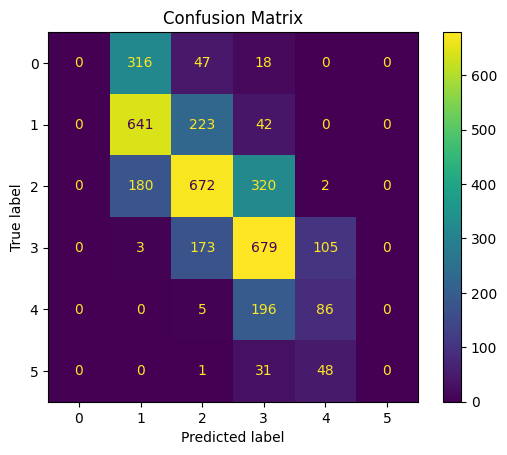

In [41]:
cm = confusion_matrix(oof_df["label"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(CFG.num_labels)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Optimal Thresholds

In [47]:
best, threshold, xs, ys = find_thresholds(oof_df["label"], oof_df["logit"], steps=500)

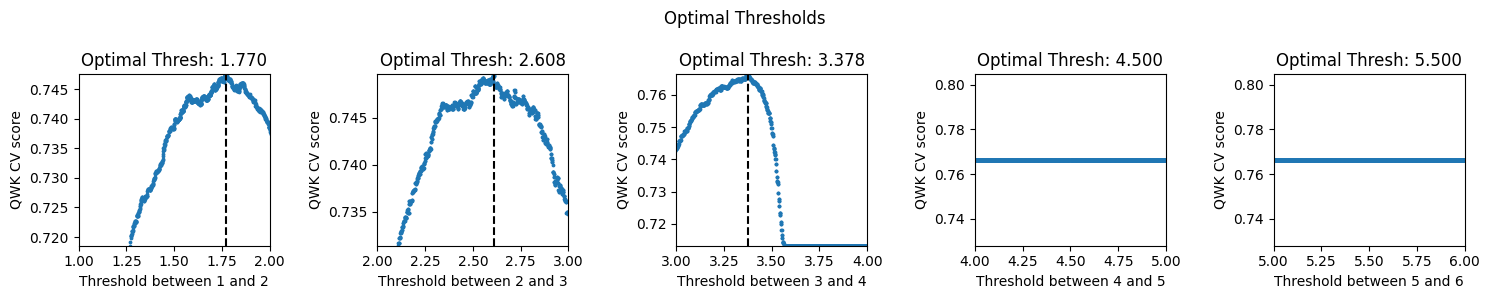

In [48]:
diff = 0.5
nrows, ncols = 1, 5  # Define grid for 5 subplots (1 row, 5 columns)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))  # Create figure and subplots

# Loop through data and plot on each subplot
for k in range(5):
    ax = axes.flat[k]  # Access each subplot using flattened axes
    ax.scatter(xs[k], ys[k], s=3)
    m = k + 1.5
    ax.set_xlim((m - diff, m + diff))
    i = np.where((np.array(xs[k]) > m - diff) & (np.array(xs[k]) < m + diff))[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    ax.set_ylim((mn, mx))

    ax.plot(
        [threshold[k], threshold[k]],
        [mn, mx],
        "--",
        color="black",
        label="optimal threshold",
    )

    ax.set_title(f"Optimal Thresh: {threshold[k]:4.3f}", size=12)  # Adjust title size
    ax.set_xlabel(f"Threshold between {k+1} and {k+2}", size=10)
    ax.set_ylabel("QWK CV score", size=10)

# Common legend for all subplots
plt.suptitle("Optimal Thresholds", size=12)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [44]:
with open(Paths.threshold_path, "wb") as file:
    pkl.dump(threshold, file)

## Wrapping up

In [45]:
wandb.finish()

CV/qwk_score,▁
eval/loss,▁
eval/qwk,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇▇████████████
train/grad_norm,██▂▇▁▃▂▃▅▃▄
train/learning_rate,▁█▇▇▆▅▅▄▄▃▂▂
train/loss,█▆▂▁▁▁▁▁▁▁▁▁


In [46]:
oof_df.head()

,essay_id,full_text,score,topic,label,fold,pred,pred_score
0,001bdc0,"We all heard about Venus, the planet without a...",4,2,3.0,0.0,3.316406,3.0
1,001bdc0,but what if scientist project the futur into t...,4,2,3.0,0.0,3.341797,3.0
2,0036253,The challenge of exploring Venus\n\nThis stori...,2,2,1.0,0.0,1.178711,1.0
3,0079f2a,In the text the author uses facts that people ...,2,2,1.0,0.0,0.822754,1.0
4,0087059,''The Challenge of Exploring Venus'' is a info...,1,2,0.0,0.0,0.752930,1.0
